# E-distance with original data

In [67]:
import os
import json
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dcor

import sys
sys.path.append("/home/yangz2/projects/1906-pcgml/pcgml-gmmVae-exp/modules/")

from metrics import Metrics
m = Metrics(game='smba')

Each of the following JSONs contain about 10000 chunks generated from a GM-VAE. The component of this GM-VAE is specificed by the last character of the file name.

In [ ]:
path_to_gens = "../smba_generations_1_to_8"
os.listdir(path_to_gens)

Define some utility functions.

In [9]:
def load_json_as_array(json_fpath):
    with open(json_fpath, "r") as json_f:
        return np.array(json.load(json_f))

In [55]:
metrics = ['linearity', 'leniency', 'num_jumps', 'density', 'interestingness']

In [56]:
def get_metrics_from_chunks(chunks):
    return m.compute_metrics_for_arrays(
        arrays=chunks, 
        metrics_to_compute=metrics
    )

Compute metrics of the generations of each GM-VAE.

In [11]:
metrics_computed = True

In [12]:
if not metrics_computed:
    metrics_per_json = []
    for json_fname in tqdm_notebook([i for i in os.listdir(path_to_gens) if i.split('.')[-1] == 'json']):
        json_fpath = os.path.join(path_to_gens, json_fname)
        chunks = load_json_as_array(json_fpath)
        metrics_per_json.append(get_metrics_from_chunks(chunks))

Save metrics for all GM-VAE in one JSON, since the computation of these metrics take time.

In [13]:
if not metrics_computed:
    metrics_per_json_np = [np.array(i) for i in metrics_per_json]

In [14]:
if not metrics_computed:
    with open('metrics_per_json.json', 'w+') as json_f:
        json.dump([i.tolist() for i in metrics_per_json_np], json_f)

Load the metrics and normalize them. Normalization is needed since different metrics are on different scales.

In [73]:
num_components_array = [8, 7, 6, 2, 3, 1, 0, 4, 5]

In [140]:
with open('metrics_per_json.json', 'r') as json_f:
    metrics_per_json_np = [np.array(i).T for i in json.load(json_f)]
    for i, mets in enumerate(metrics_per_json_np):
        metrics_per_json_np[i] = np.hstack([mets, np.ones((len(mets), 1), dtype=int) * num_components_array[i]])
    metrics_per_json_np = np.concatenate(metrics_per_json_np)

## Centroids

In [141]:
df = pd.DataFrame(metrics_per_json_np)

In [142]:
df.columns = metrics + ["components"]

In [143]:
df.head()

,linearity,leniency,num_jumps,density,interestingness,components
0,0.000000,-3.0,0.0,36.328125,3.0,8.0
1,5.838695,1.0,1.0,18.359375,1.0,8.0
2,0.000000,1.0,1.0,20.312500,0.0,8.0
3,0.000000,1.0,1.0,10.156250,0.0,8.0
4,0.000000,1.0,1.0,22.265625,0.0,8.0


In [145]:
centroids = df.groupby('components').mean()
centroids

,linearity,leniency,num_jumps,density,interestingness
components,,,,,
0.0,4.220413,0.228317,0.788362,18.754199,5.109711
1.0,2.249411,0.306000,0.464400,13.765977,1.339300
2.0,3.195026,0.354300,0.531500,14.326641,2.531300
3.0,3.041895,0.389239,0.514851,14.298813,1.994999
4.0,2.772697,0.323100,0.525000,14.465547,1.945600
5.0,2.992627,0.206200,0.607000,15.463906,1.846300
6.0,2.949607,0.252501,0.568727,14.886697,1.873449
7.0,2.446350,0.379152,0.484294,14.662584,1.584934
8.0,2.653795,0.242400,0.498900,15.558555,1.923000


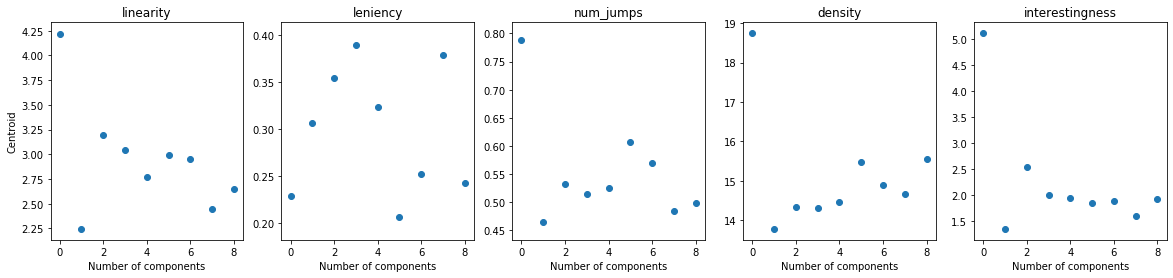

In [149]:
fig = plt.figure(figsize=(20, 4))

for i in np.arange(1, 5+1):
    
    fig.add_subplot(int(f'15{i}'))
    
    if i == 1: plt.ylabel('Centroid')
        
    mets = centroids[metrics[i-1]]
    plt.scatter(np.arange(9), mets)
    plt.title(metrics[i-1])
    plt.xlabel('Number of components')
    
plt.show()

In [36]:
# make sure all metrics are on the same scale
for i in metrics_per_json_np:
    i /= np.abs(i).max(axis=1).reshape(-1, 1)

## Compute 95% boostrap confidence interval for each distance

This section is very, very slow; it can be skipped until later.

In [41]:
def bootstrap_ci(org_mets, gen_mets, confidence_level=0.95, num_bootstraps=10):
    
    # org_mets and gen_mets are of shape (num_chunks, num_metrics)
    
    num_org = len(org_mets)
    num_gen = len(gen_mets)
    
    e_distances = []
    
    for i in tqdm_notebook(np.arange(num_bootstraps)):
    
        random_idxs_org = np.random.randint(num_org, size=num_org)
        random_idxs_gen = np.random.randint(num_gen, size=num_gen)
    
        org_mets_samp = org_mets[random_idxs_org]
        gen_mets_samp = gen_mets[random_idxs_gen]
        
        e_distances.append(dcor.energy_distance(org_mets_samp, gen_mets_samp))
        
    ordered = sorted(e_distances)
    lower = np.percentile(ordered, (1-confidence_level)/2 * 100)
    upper = np.percentile(ordered, (confidence_level+((1-confidence_level)/2)) * 100)

    return lower, upper

In [42]:
org_idx = 6
org_mets = metrics_per_json_np[org_idx]
lowers = []
uppers = []
for mets in tqdm_notebook(metrics_per_json_np):
    lower, upper = bootstrap_ci(org_mets.T, mets.T)
    lowers.append(lower)
    uppers.append(upper)

KeyboardInterrupt: 

In [ ]:
with open("lowers.json", "w+") as json_f:
    json.dump(lowers, json_f)

In [ ]:
with open("uppers.json", "w+") as json_f:
    json.dump(uppers, json_f)

In [ ]:
with open("lowers.json", "r") as json_f:
    lowers = json.load(json_f)

In [ ]:
with open("uppers.json", "r") as json_f:
    uppers = json.load(json_f)

## Compute distances

For each GMVAE, compute the energy distance between the normalized metrics of its generations with the original data.

In [42]:
distances_computed = True

In [43]:
if not distances_computed:
    org_idx = 6
    org_mets = metrics_per_json_np[org_idx]
    e_distances = []
    for i, mets in enumerate(metrics_per_json_np):
        e_distances.append(dcor.energy_distance(org_mets.T, mets.T))

In [44]:
if not distances_computed:
    with open("e_distances.json", "w+") as json_f:
        json.dump(e_distances, json_f)

In [45]:
with open("e_distances.json", "r") as json_f:
    e_distances = json.load(json_f)

In [46]:
num_components_array = [8, 7, 6, 2, 3, 1, 0, 4, 5]

## Plot distances against number of components

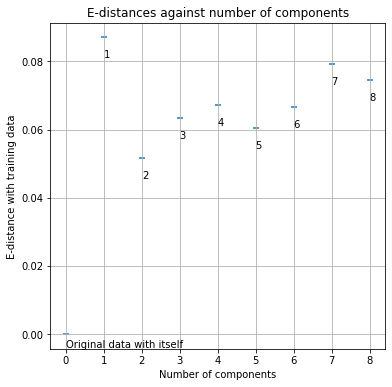

In [48]:
plt.figure(figsize=(6, 6))

plt.title('E-distances against number of components')

plt.scatter(num_components_array, e_distances, marker="_")

for x, y in zip(num_components_array, e_distances):
    if x == 0:
        plt.annotate("Original data with itself", xy=(x, y-0.004))
    else:
        plt.annotate(f"{x}", xy=(x, y-0.006))

# # confidence bounds
# plt.scatter(num_components_array, lowers, marker='_')
# plt.scatter(num_components_array, uppers, marker='_')

plt.xlabel('Number of components'); plt.ylabel('E-distance with training data')
plt.grid()

plt.show()